## CNN

In [1]:
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Subsetを用いて、学習用画像60000枚を学習用50000枚と検証用10000枚に分割

In [3]:
train_size = 50000
train_indices = list(range(0,train_size))
valid_indices = list(range(train_size, len(training_data)))

train_data = Subset(training_data, train_indices)
valid_data = Subset(training_data, valid_indices)

print(len(train_data), len(valid_data))


50000 10000


In [4]:
batch_size = 64

# データローダーの作成
train_dataloader = DataLoader(train_data, batch_size=batch_size)
validation_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# CNNを用いたモデル
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

model = CNN_model().to(device)
print(model)

Using cuda device
CNN_model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    epoch_loss /= size
    return epoch_loss

In [8]:
def validation(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= size
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")
    return validation_loss

In [9]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_predictions.extend(pred.argmax(1).cpu().tolist())
            test_labels.extend(y.cpu().tolist())
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    results = {"label": test_labels, "prdiction": test_predictions}
    df = pd.DataFrame(results)
    return df


validation損失をもとに最適epochを決定


In [10]:
epochs = 30
min_loss = 1000
model_path = "model/cnn/"
result_dir = "result/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

train_losses = []
validation_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    validation_loss = validation(validation_dataloader, model)
    validation_losses.append(validation_loss)
    if validation_loss < min_loss:
        best_epoch = t+1
        min_loss = validation_loss
    torch.save(model.state_dict(), model_path+"model_"+str(t+1)+".pth")

model = CNN_model().to(device)
model.load_state_dict(torch.load(model_path+"model_"+str(best_epoch)+".pth"))
df_label_pred = test(test_dataloader, model)
df_label_pred.to_csv(result_dir+"test_cnn.csv")

print(f"Best Epoch: {best_epoch}")
print("Done!")

Epoch 1
-------------------------------
loss: 2.310114  [    0/50000]
loss: 2.302764  [ 6400/50000]
loss: 2.296855  [12800/50000]
loss: 2.295578  [19200/50000]
loss: 2.289640  [25600/50000]
loss: 2.281558  [32000/50000]
loss: 2.288978  [38400/50000]
loss: 2.279448  [44800/50000]
Validation Error: 
 Accuracy: 18.5%, Avg loss: 0.035650 

Epoch 2
-------------------------------
loss: 2.281129  [    0/50000]
loss: 2.272364  [ 6400/50000]
loss: 2.256383  [12800/50000]
loss: 2.251945  [19200/50000]
loss: 2.244777  [25600/50000]
loss: 2.223828  [32000/50000]
loss: 2.223119  [38400/50000]
loss: 2.199803  [44800/50000]
Validation Error: 
 Accuracy: 48.2%, Avg loss: 0.034226 

Epoch 3
-------------------------------
loss: 2.201242  [    0/50000]
loss: 2.175029  [ 6400/50000]
loss: 2.117840  [12800/50000]
loss: 2.089996  [19200/50000]
loss: 2.038946  [25600/50000]
loss: 1.967040  [32000/50000]
loss: 1.896270  [38400/50000]
loss: 1.793006  [44800/50000]
Validation Error: 
 Accuracy: 54.1%, Avg los

損失グラフ作成

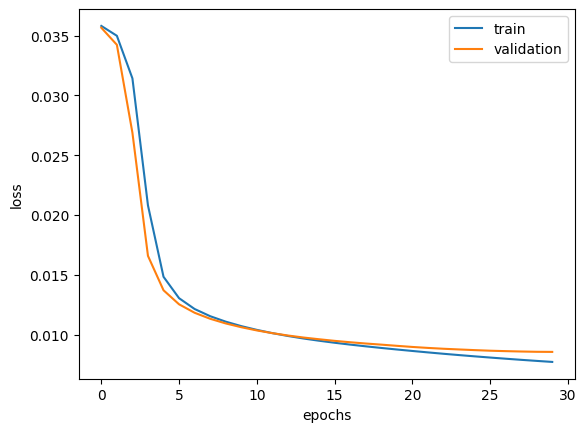

In [11]:
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()
